In [1]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys; sys.path.append("../")
from util import select_columns, plot_ESS, plot_GR
from numpyro.diagnostics import effective_sample_size, gelman_rubin

num_chains = 10
num_samples = 10000

df_1 = pd.read_csv("no.csv", index_col="draws")
df_2 = pd.read_csv("full.csv", index_col="draws")
df_3 = pd.read_csv("half.csv", index_col="draws")
df_4 = pd.read_csv("auto.csv", index_col="draws")

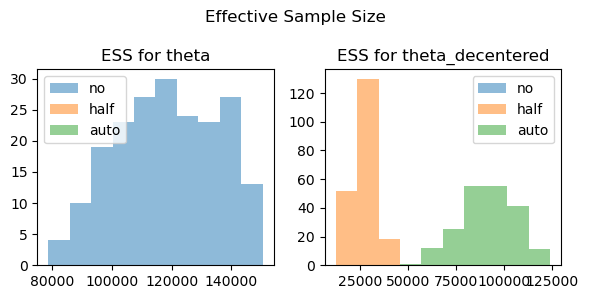

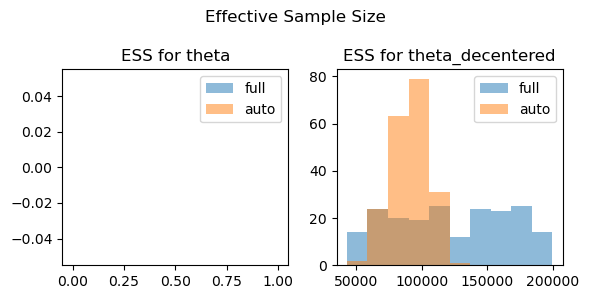

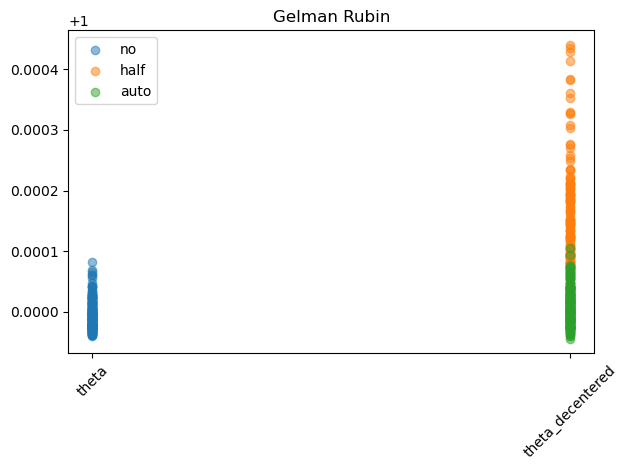

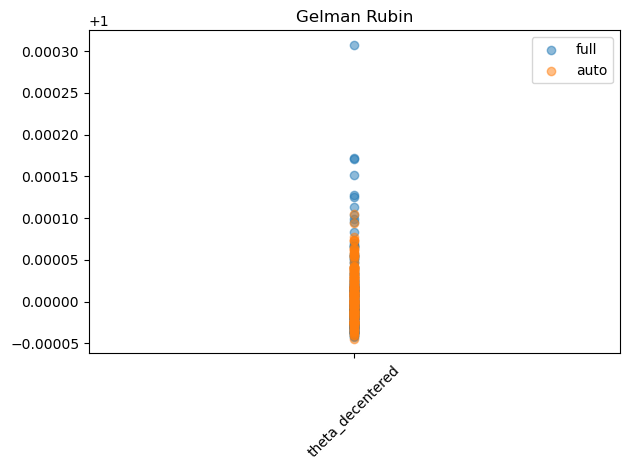

In [7]:
%matplotlib inline
dfs = [df_1, df_3, df_4]
labels = ["no", "half", "auto"]
params = ["theta", "theta_decentered"]

plot_ESS(dfs, labels, params, num_chains, num_samples)
plot_ESS([df_2, df_4], ["full", "auto"], params, num_chains, num_samples)
plot_GR(dfs, labels, params, num_chains, num_samples)
plot_GR([df_2, df_4], ["full", "auto"], params, num_chains, num_samples)

In [6]:
sample_1 = select_columns(df_1, "theta").to_numpy().reshape(num_chains, num_samples, -1)
sample_2 = select_columns(df_2, "theta_decentered").to_numpy().reshape(num_chains, num_samples, -1)
sample_3 = select_columns(df_3, "theta_decentered").to_numpy().reshape(num_chains, num_samples, -1)
sample_4 = select_columns(df_4, "theta_decentered").to_numpy().reshape(num_chains, num_samples, -1)
samples = [sample_1, sample_2, sample_3, sample_4]

In [98]:
bound = 20
step = 5

y_hmc = torch.linspace(-bound, bound, step).round()
sigma_hmc = torch.linspace(0.1, bound, step).round()
y_hmc, sigma_hmc = map(torch.flatten, torch.meshgrid(y_hmc, sigma_hmc, indexing="ij"))

dfs = []
for sample, label in zip(samples, labels):
    df = pd.DataFrame({"y": y_hmc.flatten(), "sigma": sigma_hmc.flatten()})
    df["reparam"] = label
    df["ess"] = effective_sample_size(sample)
    df["gr"] = gelman_rubin(sample)
    dfs.append(df)

df_hmc = pd.concat(dfs, axis=0)
df_hmc

,y,sigma,reparam,ess,gr
0,-20.0,0.0,no,26787.708615,1.000122
1,-20.0,5.0,no,7271.516360,1.000834
2,-20.0,10.0,no,6780.123535,1.000533
3,-20.0,15.0,no,7885.643830,1.001168
4,-20.0,20.0,no,6714.224294,1.000917
...,...,...,...,...,...
20,20.0,0.0,auto,46455.455186,1.000047
21,20.0,5.0,auto,38719.188302,1.000053
22,20.0,10.0,auto,104117.181428,1.000028
23,20.0,15.0,auto,110994.280806,0.999966


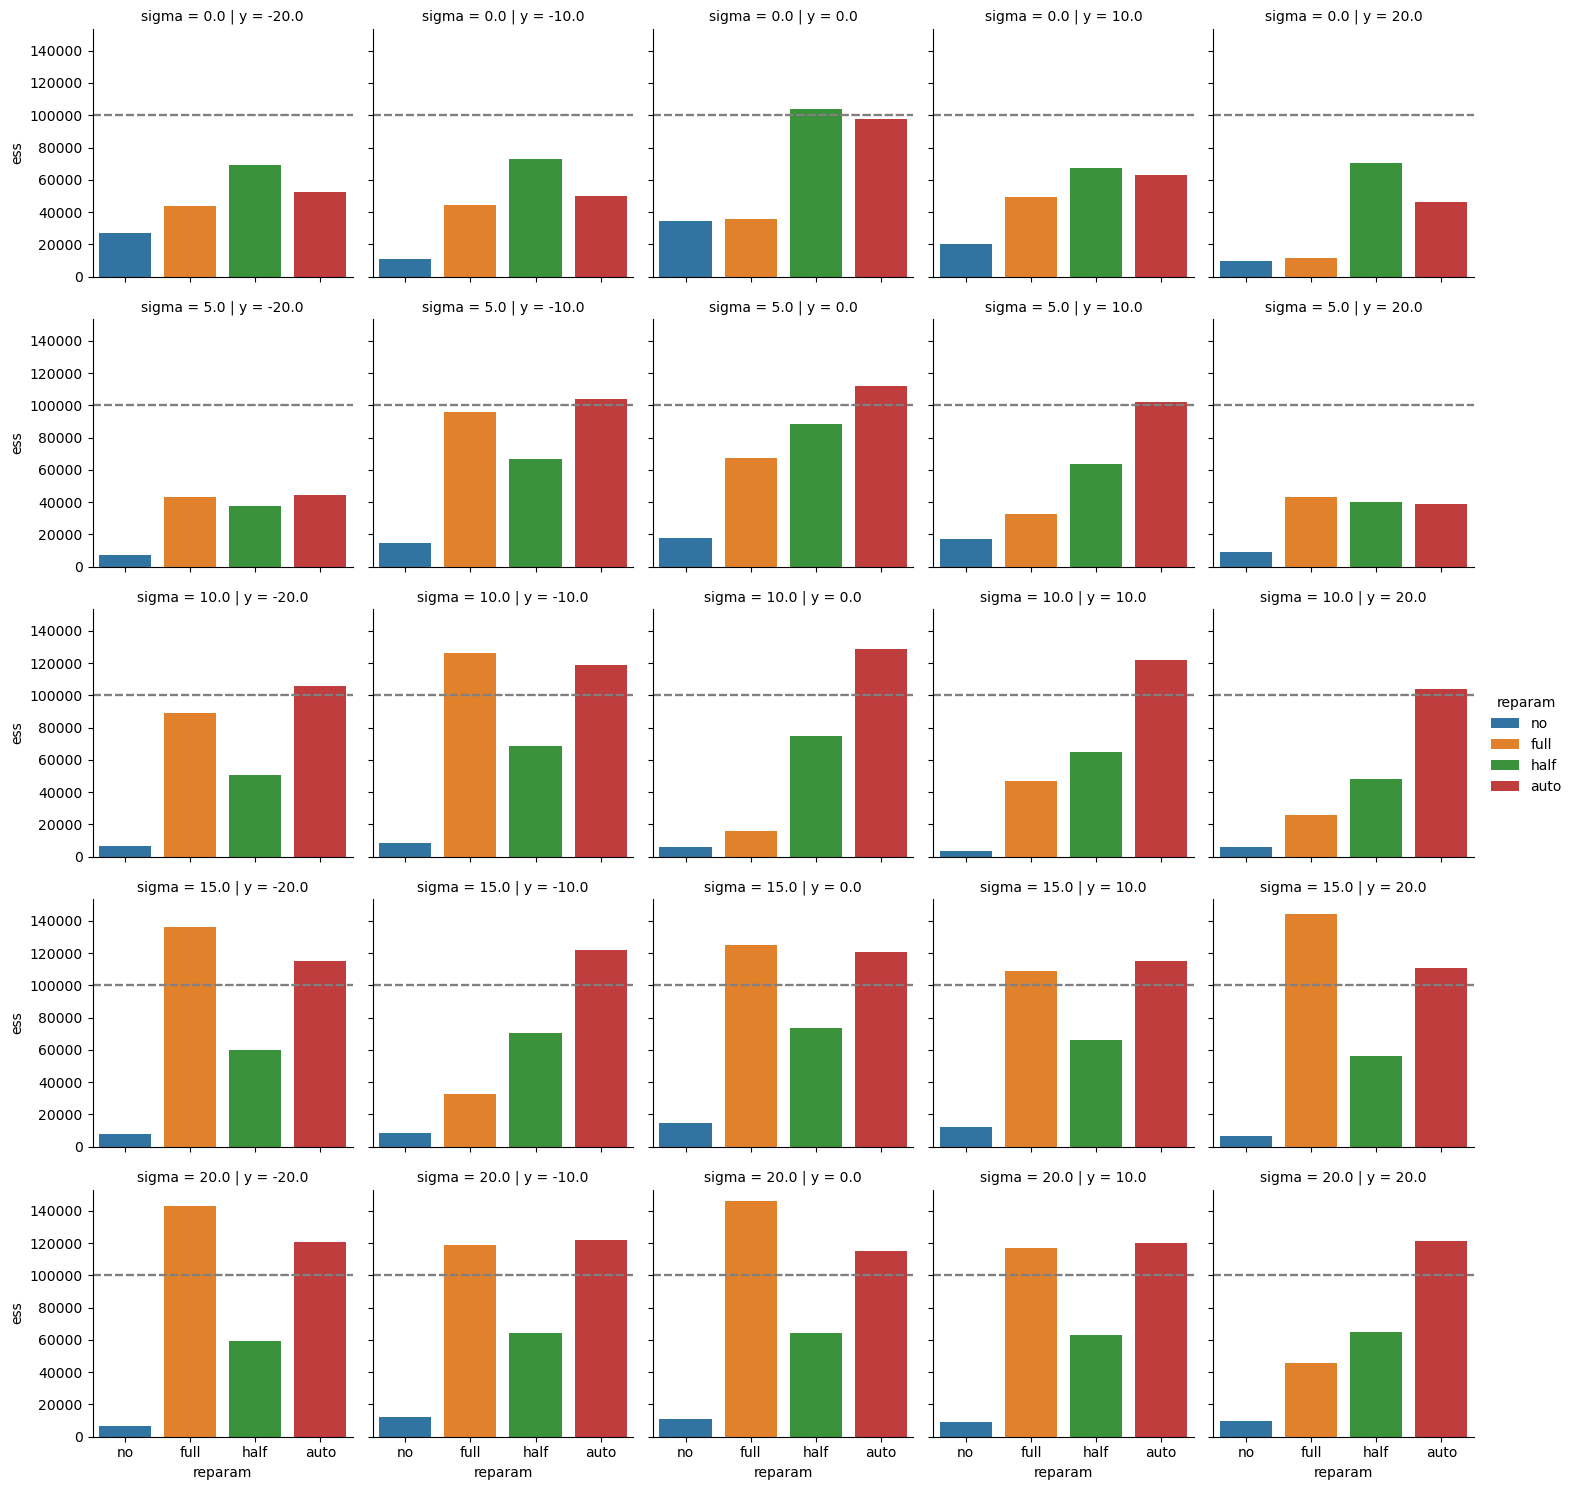

In [102]:
%matplotlib inline
order = df_hmc.reparam.unique()
g = sns.FacetGrid(df_hmc, col="y", row="sigma", hue="reparam")
g.map(sns.barplot, "reparam", "ess", order=order)
g.refline(y=num_chains * num_samples)
g.add_legend()
plt.savefig("ess.pdf")

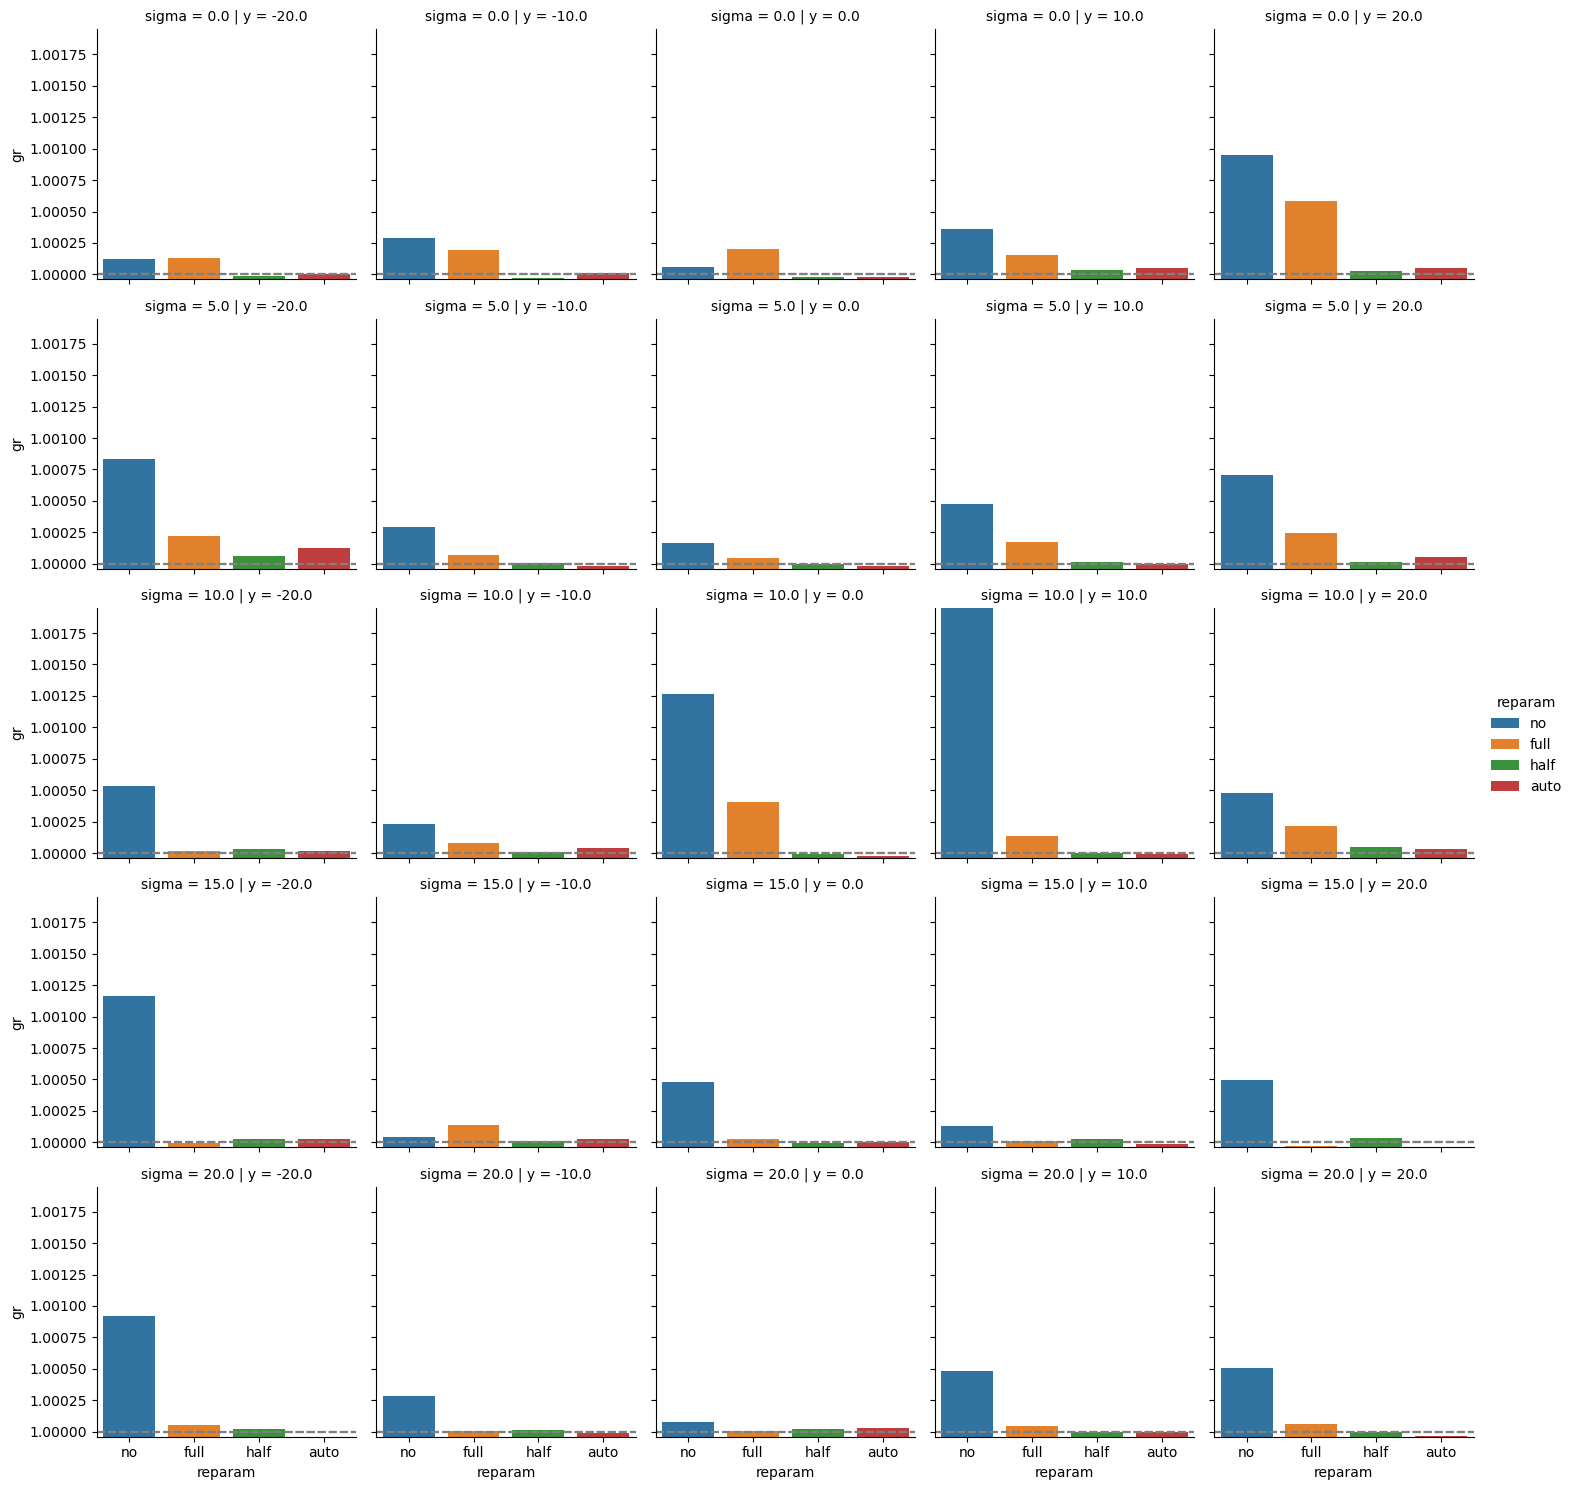

In [103]:
%matplotlib inline
order = df_hmc.reparam.unique()
g = sns.FacetGrid(df_hmc, col="y", row="sigma", hue="reparam")
g.map(sns.barplot, "reparam", "gr", order=order)
g.set(ylim=(df_hmc["gr"].min(), df_hmc["gr"].max()))
g.refline(y=1)
g.add_legend()
plt.savefig("gr.pdf")